In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

$M$ - is the number of states: 2 - fair (F) and biased (B) dice

$K$ - is the number of possible emissions: 6 - for every dice side

$L$ - is length. Let it be 250

In [2]:
L = 250

- Set transition ($M \times M$) and emission ($M \times K$) matrices and beginning distribution
(vector of length $M$).

In [3]:
#transition matrix: F->F, F->B, B->F, B->B
T = np.array([[.95, .05], [.1, .9]])
#emission matrix: 1/6 * 6 for F and .1 * 5, .5 for B
Em = np.array([[1/6 for i in range(6)], [.1, .1, .1, .1, .1, .5]])

beginning distribution $p_0$ - (P(throwing F first, P(throwing B first)). 
Distribution is stationar, so $p_0\cdot T= p_0$

In [4]:
#beginning distribution
p0 = (2/3, 1/3)

- HMM random generator: generate a sequence x of length L given the model parameters.

In [5]:
#helps us to choose one value from several, if we have the array of their probabilities
'''
1. sum of all probabilites is 1
2. choice is a random number from [0,1)
3. we substract probabilities from it till it is in [0,1)
4. the step, when it becomes negative, defines our choice
'''

def choose(probs):
    flag = np.random.random()
    i = 0
    for prob in probs:
        flag -= prob
        if flag < 0:
            return i
        i += 1

Now we have to create hidden and obsrved sequences

In [6]:
'''
Hidden sequence is responsible for dice choices
The first state is chosen according to beginning distribation. 
The next states are  - according to transition probabilities.
'''
def hidden_seq(start_dice, trans, length):
    seq = np.zeros(length, dtype=int)
    seq[0] = choose(start_dice)
    for i in range(1, length):
        dice = trans[seq[i-1]]
        seq[i] = choose(dice)
    return seq

In [7]:
'''
observed sequence (= sequence x) is responsible for dice faces
it is based on hidden sequence and emission probabilities
'''
def observed_seq(hidden, emission):
    length = len(hidden)
    seq = np.zeros(length, dtype=int)
    for i in range(length):
        face = emission[hidden[i]]
        seq[i] = choose(face)
    return seq

- Use Viterbi algorithm to find the most probable path π given x and HMM parameters.

<img src='1.png'></img>

In [8]:
#finds most likely dice choices, knowing dice faces
'''
x - observed sequence
a - transition matrix
e - emission matrix

We will work in log format
'''
def viterbi(start_dice, x, a, e):
    L = len(x)
    V = np.zeros((2, L))
    ptr = np.zeros((L, 2))
    
    #initialisation (changed, comparing to the tutorial, i.e. we know our distribution)
    V[ :, 0] = np.log(start_dice) + np.log(e[:, x[0]]) 
    #remember: since V is already log, don't write np.log(V[,]) 
    
    #recursion
    for i in range(1, L):
        for l in range(2):
            V[l, i] = np.log(e[l, x[i]]) + np.max(V[:, i - 1] + np.log(a[:, l]))
            ptr[i, l] = np.argmax(V[:, i - 1] + np.log(a[:, l]))
    
    seq = np.zeros(L, dtype=int)
    
    #termintation
    seq[-1] = np.argmax(V[:, -1] + np.log(a[:, -1]))
    
    #traceback
    for i in range(L - 1, 0, -1):
        seq[i - 1] = ptr[i, seq[i]]
    return seq

- Plot and compare the simulated path and Viterbi most likely path.

In [9]:
h = hidden_seq(p0, T, L)
ob = observed_seq(h, Em)
vit = viterbi(p0, ob, T, Em)

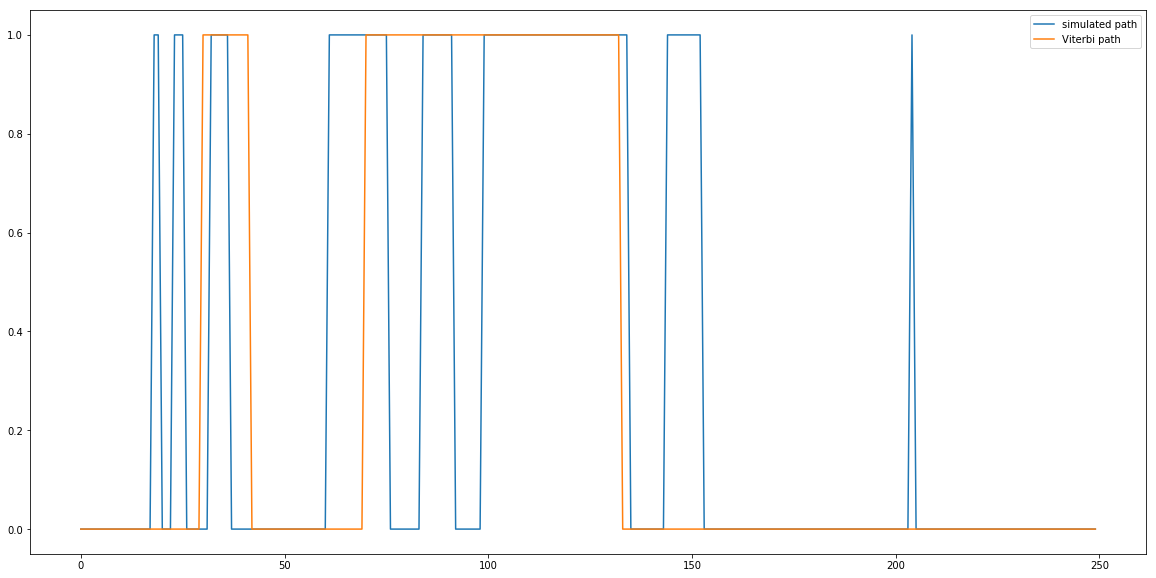

In [10]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(range(L), h, label='simulated path')
ax.plot(range(L), vit, label='Viterbi path')
ax.legend()

- Find the probability $P(x)$ using forward algorithm (store the full matrix of forward probabilities $f_k(x_i)$ in order to use it for posterior decoding later on).

<img src='2.png'></img>

Since there are only two terms in recursion and termination sums, we can straight apply this formula to expand our logarithm formula
<img src='3.png'></img>

In [11]:
#finds the probability of the observed sequence
'''
x - observed sequence
a - transition matrix
e - emission matrix

We will work in log format
'''
def forward(start_dice, x, a, e):
    L = len(x)
    f = np.zeros((2, L))
    #initialisation
    f[:, 0] = np.log(start_dice) + np.log(e[:, x[0]])
    #recursion
    for i in range(1, L):
        for l in range(2):
            log_term1 = f[0, i - 1] + np.log(a[0, l])
            log_term2 = np.log(1 + np.e ** (f[1, i - 1] + np.log(a[1, l]) - log_term1))
            log_sum = log_term1 + log_term2
            f[ l, i] = np.log(e[ l, x[i]]) + log_sum
    #termintation
    f_probs = f[0, -1] + np.log(1 + np.e ** (f[1, -1] - f[0, -1]))
    return f, f_probs

In [12]:
f, f_probs = forward(p0, ob, T, Em)

- Implement the backward algorithm.

<img src='4.png'></img>

In [13]:
'''
x - observed sequence
a - transition matrix
e - emission matrix

We will work in log format
'''
def backward(start_dice, x, a, e):
    L = len(x)
    b = np.zeros((2, L))
    #initialisation
    b[:, -1] = 1
    #recursion
    for i in range(L - 2, -1, -1):
        for k in range(2):
            log_term1 = b[0, i + 1] + np.log(a[k, 0]) + np.log(e[0, x[i + 1]])
            log_term2 = np.log(1 + np.e ** (b[1, i + 1] + np.log(a[k, 1]) + np.log(e[1, x[i + 1]]) - log_term1))
            b[k, i] = log_term1 + log_term2
    #termintation
    log_term1 = b[0, 1] + np.log(start_dice[0]) + np.log(e[0, x[1]])
    log_term2 = np.log(1 + np.e ** (b[1, 1] + np.log(start_dice[1]) + np.log(e[1, x[1]]) - log_term1))
    b_probs = log_term1 + log_term2
    return b, b_probs

In [14]:
b, b_probs = backward(p0, ob, T, Em)

- Implement posterior decoding.

In [15]:
#log format graph wasn't demonstrative enough, so I had to use "ordinary" probabilities
post_probs = np.multiply(np.e ** f, np.e ** b) / np.e ** f_probs
post_probs /= np.max(post_probs)

In [16]:
print(f_probs, b_probs)

-437.5656843636581 -434.5220868959937


Close enough

- Plot posterior probability $P(fair)$. Compare with the regions of the simulated path where loaded dice was used.

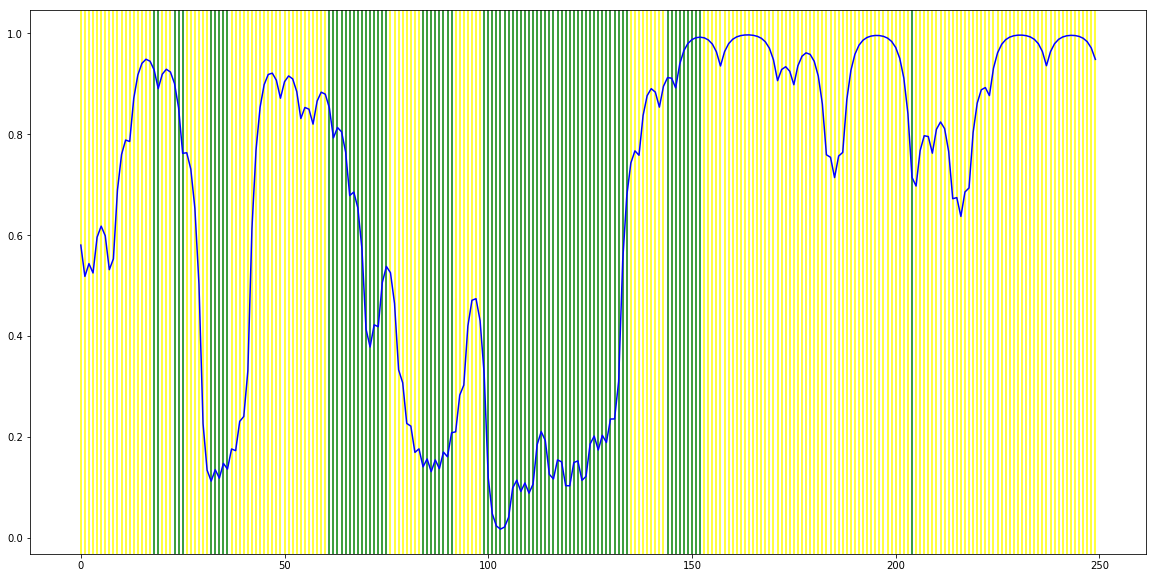

In [17]:
#hidden sequence vs post_probs[fair]
fig, ax = plt.subplots(figsize=(20, 10))
for i in range(L):
    if h[i] == 0:
        ax.axvline(i, color='yellow')
    else:
        ax.axvline(i, color='green')
ax.plot(range(L), post_probs[0], color='b')

Spikes quite match with yellow areas. Gues, we did right

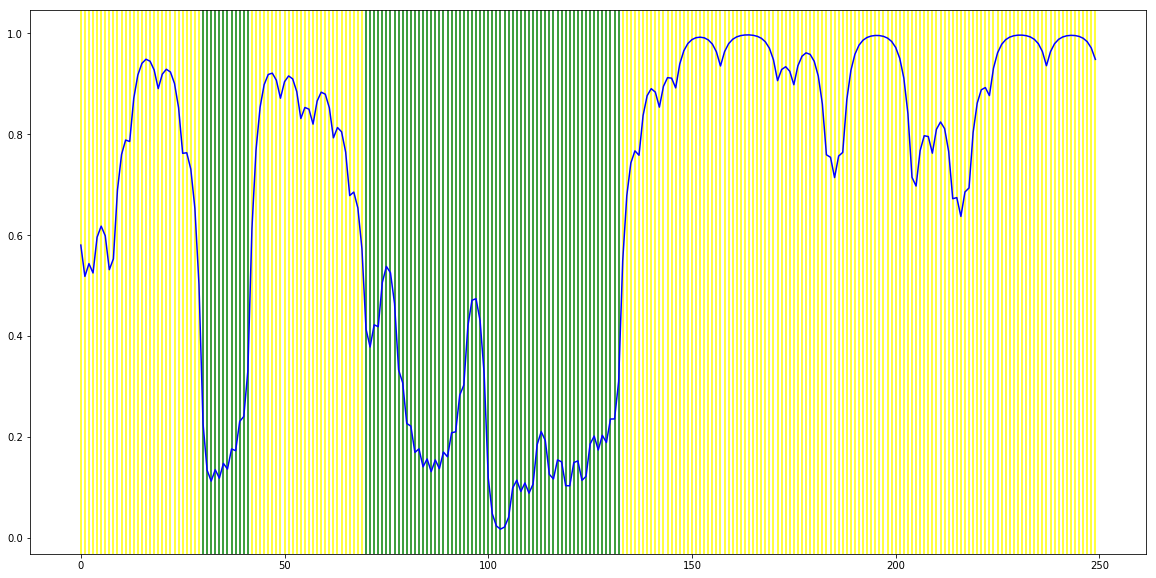

In [18]:
#viterbi sequence vs post_probs[fair]
fig, ax = plt.subplots(figsize=(20, 10))
for i in range(L):
    if vit[i] == 0:
        ax.axvline(i, color='yellow')
    else:
        ax.axvline(i, color='green')
ax.plot(range(L), post_probs[0], color='b')